[@LorenaABarba](https://twitter.com/LorenaABarba)

12 steps to Navier–Stokes
======
***

You should have completed Steps [1](./01_Step_1.ipynb) and [2](./02_Step_2.ipynb) before continuing. This Jupyter notebook continues the presentation of the **12 steps to Navier–Stokes**, the practical module taught in the interactive CFD class of [Prof. Lorena Barba](http://lorenabarba.com). 

Step 3: Diffusion Equation in 1-D
-----
***

The one-dimensional diffusion equation is:

$$\frac{\partial u}{\partial t}= \nu \frac{\partial^2 u}{\partial x^2}$$

The first thing you should notice is that —unlike the previous two simple equations we have studied— this equation has a second-order derivative. We first need to learn what to do with it!

### Discretizing $\frac{\partial ^2 u}{\partial x^2}$

The second-order derivative can be represented geometrically as the line tangent to the curve given by the first derivative.  We will discretize the second-order derivative with a Central Difference scheme: a combination of Forward Difference and Backward Difference of the first derivative.  Consider the Taylor expansion of $u_{i+1}$ and $u_{i-1}$ around $u_i$:

$u_{i+1} = u_i + \Delta x \frac{\partial u}{\partial x}\bigg|_i + \frac{\Delta x^2}{2} \frac{\partial ^2 u}{\partial x^2}\bigg|_i + \frac{\Delta x^3}{3!} \frac{\partial ^3 u}{\partial x^3}\bigg|_i + O(\Delta x^4)$

$u_{i-1} = u_i - \Delta x \frac{\partial u}{\partial x}\bigg|_i + \frac{\Delta x^2}{2} \frac{\partial ^2 u}{\partial x^2}\bigg|_i - \frac{\Delta x^3}{3!} \frac{\partial ^3 u}{\partial x^3}\bigg|_i + O(\Delta x^4)$

If we add these two expansions, you can see that the odd-numbered derivative terms will cancel each other out.  If we neglect any terms of $O(\Delta x^4)$ or higher (and really, those are very small), then we can rearrange the sum of these two expansions to solve for our second-derivative.  


$u_{i+1} + u_{i-1} = 2u_i+\Delta x^2 \frac{\partial ^2 u}{\partial x^2}\bigg|_i + O(\Delta x^4)$

Then rearrange to solve for $\frac{\partial ^2 u}{\partial x^2}\bigg|_i$ and the result is:

$$\frac{\partial ^2 u}{\partial x^2}=\frac{u_{i+1}-2u_{i}+u_{i-1}}{\Delta x^2} + O(\Delta x^4)$$


### Back to Step 3

We can now write the discretized version of the diffusion equation in 1D:

$$\frac{u_{i}^{n+1}-u_{i}^{n}}{\Delta t}=\nu\frac{u_{i+1}^{n}-2u_{i}^{n}+u_{i-1}^{n}}{\Delta x^2}$$

As before, we notice that once we have an initial condition, the only unknown is $u_{i}^{n+1}$, so we re-arrange the equation solving for our unknown:

$$u_{i}^{n+1}=u_{i}^{n}+\frac{\nu\Delta t}{\Delta x^2}(u_{i+1}^{n}-2u_{i}^{n}+u_{i-1}^{n})$$

The above discrete equation allows us to write a program to advance a solution in time. But we need an initial condition. Let's continue using our favorite: the hat function. So, at $t=0$, $u=2$ in the interval $0.5\le x\le 1$ and $u=1$ everywhere else. We are ready to number-crunch!

In [6]:
import numpy                     #loading our favorite library
from matplotlib import pyplot    #and the useful plotting library
%matplotlib inline

nx = 128
domain_length = 64
dx = domain_length / (nx-1)
xspace = numpy.linspace(0, domain_length, nx)

nt = 100  #the number of timesteps we want to calculate
nu = 5   #the value of viscosity
sigma = .2 #sigma is a parameter, we'll learn more about it later
dt = sigma * dx**2 / nu #dt is defined using sigma ... more later!

u_IC = numpy.ones(nx)      #numpy function ones()
u_IC[int((nx-1)/4):int(nx/2 + 1)] = 2 #setting u = 2 between 0.5 and 1 as per our I.C.s


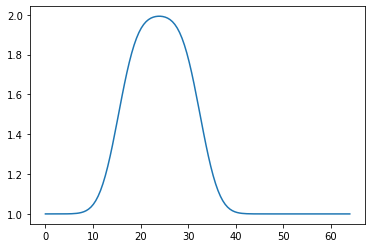

In [8]:

def calc_diffusion(IC,nx,nt,nu,dt):
    u = IC.copy()
    un = IC.copy() #our placeholder array, un, to advance the solution in time

    for n in range(nt):  #iterate through time
        un = u.copy() ##copy the existing values of u into un
        for i in range(1, nx - 1):
            u[i] = un[i] + nu * dt / dx**2 * (un[i+1] - 2 * un[i] + un[i-1])
    return u

u_FD = calc_diffusion(u_IC,nx,nt,nu,dt)
pyplot.plot(xspace, u_FD)


# Advection-Diffusion of a Gaussian Hill

In case of an isotropic diffusion, the analytical solution describing evolution of a Gaussian Hill can be expressed as 

$$
C(\boldsymbol{x}, t)=\frac{\left(2\pi\sigma_{0}^{2}\right)^{D/2} }{\left(2\pi(\sigma_{0}^{2} + 2 k t)\right)^{D/2}} 
C_0 \exp \left(-\frac{\left(\boldsymbol{x}-\boldsymbol{x}_{0}-\boldsymbol{u} t\right)^{2}}{2\left(\sigma_{0}^{2}+ 2 k t\right)}\right)
$$

where:

* $C_0$ - initial concentration,
* $D$ - number of dimensions, 
* $t$ - time, 
* $k$ - conductivity, 
* $\boldsymbol{u}$ - velocity of advection
* $\sigma_{0}$ the initial variance of the distribution.

## Task

1) Implement the `GaussianHillAnal` class. 
It shall have a method `get_concentration_ND(self, X, t)`, which will return the concentration at given time and space.

2) Benchmark the FD code against analytical solution.

In [10]:
from sympy.matrices import Matrix
import numpy as np
import sympy as sp

class GaussianHillAnal:
    def __init__(self, C0, X0, Sigma2_0, k, U, D):
        """
        :param C0: initial concentration
        :param X0: initial position of the hill's centre = Matrix([x0, y0])
        :param U:  velocity = Matrix([ux, uy])
        :param Sigma2_0: initial width of the Gaussian Hill
        :param k: conductivity
        :param dimenions: number of dimensions
        """
        self.C0 = C0
        self.X0 = X0
        self.U = U
        self.Sigma2_0 = Sigma2_0
        self.k = k
        self.dim = D

    def get_concentration_ND(self, X, t):
        decay = 2.*self.k*t
        L = X - self.X0 - self.U*t
        C = self.C0
        C *= pow(2. * np.pi * self.Sigma2_0, self.dim / 2.)
        C /= pow(2. * np.pi * (self.Sigma2_0 + decay), self.dim / 2.)
        C *= sp.exp(-(L.dot(L)) / (2.*(self.Sigma2_0 + decay)))
        return C



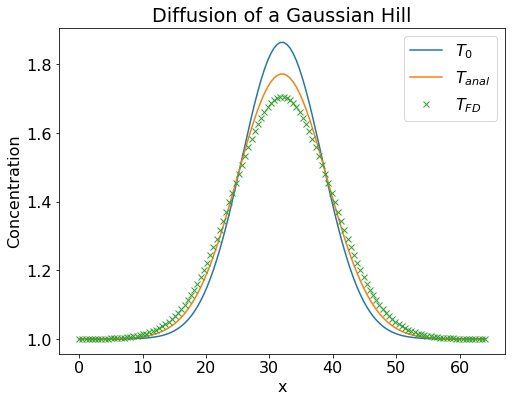

In [11]:
conductivity = nu

nt = 200  #the number of timesteps we want to calculate
nu = 5   #the value of viscosity
sigma = .2 #sigma is a parameter, we'll learn more about it later
dt = sigma * dx**2 / conductivity #dt is defined using sigma ... more later!

time_0    = dt*nt/2     # initial contidion for FD
time_spot = dt*nt       # time to be simulated (by FD and analytically)

X0 = Matrix([domain_length/2.]) # center of the hill
C0 = 1.                 # concentration
variance = 30           # initial variance
reference_level = 1     

T_0 = np.zeros(nx)
T_anal = np.zeros(nx)

gha = GaussianHillAnal(C0, X0, variance, conductivity, Matrix([0]), D=1)

for i in range(nx):
    T_0[i] = reference_level + gha.get_concentration_ND(Matrix([xspace[i]]), time_0)  
    T_anal[i] = reference_level + gha.get_concentration_ND(Matrix([xspace[i]]), time_spot)  

T_FD = calc_diffusion(T_0,nx,nt,nu,dt)


import matplotlib.pyplot as plt
plt.rcParams.update({'font.size': 16})
figure, axis = plt.subplots(1, 1, figsize=(8, 6))
plt.subplots_adjust(hspace=1)
axis.set_title('Diffusion of a Gaussian Hill')
axis.plot(xspace, T_0, label=r'$T_{0}$')
axis.plot(xspace, T_anal, label=r'$T_{anal}$')
axis.plot(xspace, T_FD, label=r'$T_{FD}$', marker='x', linestyle="", markevery=1)
axis.set_xlabel('x')
axis.set_ylabel('Concentration')
axis.legend(loc="upper right")


## Questions:

* How do you find the FD solution compared to analytical one? Experiment with different dx, dt.

* How would you asses that your mesh is fine enought in a real CFD simulation (without analytical solution)? 

## Answers

* Mesh convergence study

# Balance of Enthalpy

The simplified balance of Enthalpy $H=\rho c_p T$ is known as:
\begin{align}
\int \frac{\partial }{\partial t} (\rho c_p T ) dV +  \oint  ( \rho c_p T \boldsymbol{u} ) \cdot \boldsymbol{n} dS &= \oint \boldsymbol{n} \cdot \boldsymbol{q} dS + \int \dot{q} dV \\ 
\boldsymbol{q} &= k \nabla T
\end{align}
The heat flux $ \boldsymbol{q} $ is related to the thermal conductivity coefficient $k [ W/mK] $. 

Applying the GGO theorem, we obtain:

$$
\frac{\partial }{\partial t} (\rho c_p T ) + \nabla \cdot (\boldsymbol{u} \rho c_p T ) = \nabla \cdot (k \nabla T)  + \dot{q} 
$$




## Conservative and non-conservative scheme

Consider a 1D, unsteady heat transfer equation with variable conduction coefficient.
For simplicity, assume that the heat capacity $ \rho c_p = 1 $.

The equation be expressed in two mathematically equivalent forms:
$$
\frac{\partial u}{\partial t}=\frac{\partial}{\partial x}\left(k(x) \frac{\partial u}{\partial x}\right) \\
$$
or 
$$
\frac{\partial u}{\partial t}=\frac{\partial u}{\partial x} \frac{\partial k}{\partial x}+k(x) \frac{\partial^{2} u}{\partial x^{2}}
$$

Both of these continous forms can be discretized. 

First form leads to the *conservative scheme*

$$
\frac{u_{i}^{n+1}-u_{i}^{n}}{\Delta t}=\frac{1}{\Delta x^{2}}\left(k_{i+\frac{1}{2}}\left(u_{i+1}^{n}-u_{i}^{n}\right)-k_{i-\frac{1}{2}}\left(u_{i}^{n}-u_{i-1}^{n}\right)\right)
$$


while the second form results in a *non-conservative scheme*

$$
\frac{u_{i}^{n+1}-u_{i}^{n}}{\Delta t}=\frac{1}{\Delta x^{2}}\left(\frac{\left(k_{i+1}-k_{i-1}\right)}{2} \frac{\left(u_{i+1}^{n}-u_{i-1}^{n}\right)}{2}+k_{i}\left(u_{i+1}^{n}+u_{i-1}^{n}-2 u_{i}^{n}\right)\right)
$$


## Task

* Implement both the *conservative* and the *non-conservative* schemes.

* Impose the following BC: 

```
u[int(nx/4)] = 10.
u[-int(nx/4)] = 1.

u[0] = 5.
u[-1] = 5.
```

* Run the simulation for different $k$ and compare results. Which physical quantity may become *not conserved* ?

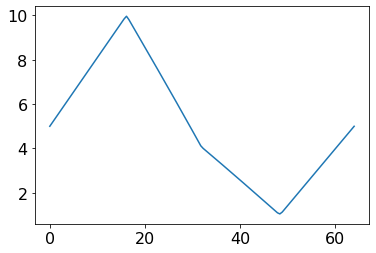

In [12]:
# variable conductivity
k = 1.*numpy.ones(nx)                   # be aware that dt = sigma * dx**2 / nu
k[:int(nx/2)] = 0.5                     # try with 0.1 

u_IC = 5.*numpy.ones(nx)                 #numpy function ones()
u_IC[int((nx-1)/4):int(nx/2 + 1)] = 10   #setting u = 2 between 0.5 and 1 as per our I.C.s
dt = sigma * dx**2 / max(k)              #dt is defined using sigma 

nt = 10000  # the number of timesteps we want to calculate

def calc_diffusion_variable_conductivity(IC,nx,nt,k,dt):
    u = IC.copy()
    un = IC.copy() #our placeholder array, un, to advance the solution in time

    for n in range(nt):  #iterate through time
        u[int(nx/4)] = 10.
        u[-int(nx/4)] = 1.

        u[0] = 5.
        u[-1] = 5.

        un = u.copy() ##copy the existing values of u into un
        for i in range(1, nx - 1):
            # this is obviously bad : du/dt = k (d^2)u/(dx)^2 
            # u[i] = un[i] + k[i] * dt / dx**2 * (un[i+1] - 2 * un[i] + un[i-1])

            # non conservative scheme
            u[i] = un[i] +  dt / dx**2 * ((k[i+1]-k[i-1])*(un[i+1]-un[i-1])/4.  + k[i]*(un[i+1] - 2 * un[i] + un[i-1]))

            # conservative scheme
            # kf = (k[i+1]+k[i])/2
            # kb = (k[i]+k[i-1])/2
            # u[i] = un[i] +  dt / dx**2 * (kf*(un[i+1]-un[i]) - kb*(un[i] - un[i-1]))

    return u

u_FD = calc_diffusion_variable_conductivity(u_IC,nx,nt,k,dt)
pyplot.plot(xspace, u_FD)

## Learn More

For a careful walk-through of the discretization of the diffusion equation with finite differences (and all steps from 1 to 4), watch **Video Lesson 4** by Prof. Barba on YouTube.

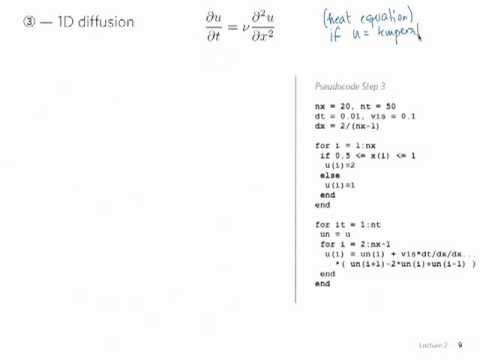

In [13]:
from IPython.display import YouTubeVideo
YouTubeVideo('y2WaK7_iMRI')

In [14]:
from IPython.core.display import HTML
def css_styling():
    styles = open("../styles/custom.css", "r").read()
    return HTML(styles)
css_styling()

> (The cell above executes the style for this notebook.)